In [1]:
import os, pickle, h5py, re
import pandas as pd
import numpy as np
from sklearn.mixture import BayesianGaussianMixture

In [2]:
os.environ['PATH'] = '/opt/anaconda3/bin:/opt/anaconda3/condabin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin'

In [3]:
os.chdir('/Volumes/Elements/10X bam')

In [8]:
def get_top_genes(file_name, n_genes=100):
    dset = h5py.File(file_name, 'r')
    dset = dset['matrix']
    indices = dset['indices']
    data = dset['data']
    features = dset['features']
    ids = features['id']
    
    temp = pd.DataFrame({'count':data,'gene':indices})
    temp = temp.groupby('gene').sum()
    temp = temp.reset_index()
    
    ensemble = pd.Series(ids).astype('str').str.replace('b','').reset_index()
    
    temp = pd.merge(left=temp,right=ensemble,how="left",left_on='gene',right_on='index')
    top_genes = temp.sort_values('count',ascending=False)[0].head(n_genes)
    
    return top_genes

In [3]:
os.chdir('/Users/beth/Documents/Python')

In [265]:
import pickle

In [5]:
with open('gene_expression_10xPBMC.pickle', 'rb') as read_file:
    gene_exp = pickle.load(read_file)

In [8]:
top_genes = gene_exp.sort_values('count')[0].tail(100)

In [3]:
os.chdir('/Volumes/BethMac/hg38')

In [5]:
def gtf_top_genes(top_genes):
    exon_list=[]
    chrom_list=[]
    for i in top_genes:
        #print(i)
        ensembl = !grep $i hg38.ensGene.gtf | cut -f1,3,4,5 #searching the gtf file is very slow
        try:
            exons = list(map(lambda x: ('\texon') in x, ensembl))
            ensembl = np.array(ensembl)
            ensembl = ensembl[exons]
            chrom = re.findall('(chr[^\t]*)',ensembl[0])[0]
            temp = list(map(lambda x: set(x), map(lambda x: range(int(re.findall('\t([0-9]*)',x)[1]),\
                                                      int(re.findall('\t([0-9]*)',x)[2])), ensembl)))
            exons = set([i for i in temp for i in i])
            exon_list.append(exons)
            chrom_list.append(chrom)
        except: #in case id is not in ensembl for some reason
            exon_list.append(0)
            chrom_list.append(0)
            
    df  = pd.DataFrame({'gene_id':top_genes, 'chrom':chrom_list, 'exons':exon_list})
    df = df[df['chrom'] != 0] 
    return df

In [25]:
os.chdir('/Volumes/Elements/10X bam')

In [24]:
def samtools_view(df): 
    df = df.reset_index()
    read_stops_list_of_list=[]
    barcodes_list_of_list = []
    for i in range(len(df)):
        print(i)
        chrom = df.loc[i,'chrom']
        start = min(df.loc[i, 'exons'])
        stop = max(df.loc[i, 'exons'])
        view = !samtools view '/Volumes/Elements/10x bam/Parent_NGSC3_DI_PBMC_possorted_genome_bam.bam' $chrom:$start-$stop 
        barcodes = list(map(lambda x: re.findall('CB:Z:([A-Z]+-[0-9]+)', x),view))
        read_starts = list(map(lambda x: x.split('\t')[3],view))
        cigars = list(map(lambda x: x.split('\t')[5],view))
        cigars = list(map(lambda x: re.findall('[0-9]+', x), cigars))
        cigars = list(map(lambda x: sum([int(s) for s in x]), cigars))
        read_stops = np.array(list(map(int,read_starts))) - start + np.array(cigars)
        read_stops_list_of_list.append(read_stops)
        barcodes_list_of_list.append(barcodes)
    df['barcodes'] = barcodes_list_of_list
    df['read_stops'] = read_stops_list_of_list
    return df

In [15]:
top_genes = get_top_genes('/Volumes/Elements/10X bam/Parent_NGSC3_DI_PBMC_filtered_feature_bc_matrix.h5',n_genes=1100)

In [17]:
top_genes = top_genes[100:]

In [21]:
top_genes

8071     'ENSG00000124614'
7564     'ENSG00000204628'
4844     'ENSG00000114391'
12063    'ENSG00000026025'
20568    'ENSG00000184009'
               ...        
14060    'ENSG00000110324'
23568    'ENSG00000159128'
23608    'ENSG00000182670'
12159    'ENSG00000120616'
15414    'ENSG00000135090'
Name: 0, Length: 1000, dtype: object

In [18]:
#top genes were MALAT, b2M, mitochondrial, even at 100 translational initiation, ribosomal, I think arbitrarily I will cut off top 100 as housekeepers/uninteresting so this runs faster

In [22]:
os.chdir('/Volumes/BethMac/hg38')

In [23]:
df = gtf_top_genes(top_genes)

In [20]:
df.head()

,gene_id,chrom,exons


In [26]:
df = samtools_view(df)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [15]:
df.head()

,index,gene_id,chrom,exons,barcodes,read_stops
0,14418,'ENSG00000069493',chr12,"{9699328, 9699329, 9699330, 9699331, 9699332, ...","[[GCAGCCACACATTACG-1], [GCAGCCACACATTACG-1], [...","[268576, 268576, 268576, 29204, 24697, 24697, ..."
1,14076,'ENSG00000118058',chr11,"{118489792, 118489793, 118489794, 118489795, 1...","[[GTAATCGCATGGAACG-1], [GATGGAGTCGAGAAAT-1], [...","[112362, 127984, 125067, 125067, 150265, 15026..."
2,13664,'ENSG00000175463',chr11,"{67403915, 67403916, 67403917, 67403918, 67403...","[[GTCAGCGTCGCTACAA-1], [AATCACGGTACTCAAC-1], [...","[31673, 13159, 186473, 143509, 175142, 198299,..."
3,22587,'ENSG00000170906',chr19,"{54108440, 54108441, 54108442, 54108443, 54108...","[[TCAAGTGTCGGAGCAA-1], [TCAAGTGTCGGAGCAA-1], [...","[8679, 8679, 1634, 26767, 83401, 27795, 369268..."
4,7421,'ENSG00000043462',chr5,"{170262635, 170262636, 170262637, 170262638, 1...","[[CAATTTCAGAACAAGG-1], [GTAACCAAGCAGAAAG-1], [...","[341169, 1918, 1919, 53075, 53076, 53076, 5307..."


In [27]:
def get_rid_of_no_barcode(df):
    list_of_new_read_stops_lists=[]
    for i in range(len(df)):
        print(i)
        keep = list(pd.Series(map(len,df.loc[i,'barcodes']))!=0)
        df.loc[i,'barcodes'] = list(pd.Series(df.loc[i,'barcodes'])[keep])
        list_of_new_read_stops_lists.append(list(pd.Series(df.loc[i,'read_stops'])[keep]))
    df['read_stops_new']=list_of_new_read_stops_lists
    df.drop('read_stops',axis=1,inplace=True)
    return df

In [28]:
df = get_rid_of_no_barcode(df)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [29]:
df = df.rename(columns={'read_stops_new':'read_stops'})

In [ ]:
1+2

In [33]:
counts, summaries = seperate_into_peaks(df)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


17
18
19


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


20
21
22
23


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


24
25
26
27
28
29
30


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


31
32
33


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


34


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


35
36
37


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


38
39
40


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


41


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


42
43


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


44
45
46
47
48
49
50
51
52
53
54
55
56


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


57
58


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


59
60
61


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


62
63
64
65
66
67
68


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


69
70


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


71
72
73
74
75
76


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


77
78
79
80
81
82
83
84
85


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


86
87
88
89


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


90
91
92
93


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


94
95
96
97
98


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


99
100
101
102
103
104
105
106
107
108


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


109
110


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


111
112
113
114


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


115


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


116
117
118
119


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


120
121
122
123
124


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


125


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


126
127


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


128
129


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


130
131
132
133
134
135


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


136
137
138


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


139


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


140


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


141
142
143
144
145
146
147
148
149
150
151
152
153
154
155


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


156
157
158
159


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


160


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


161


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


162
163
164
165
166
167
168


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


169
170


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


171
172
173
174
175
176
177


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


178


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


179


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


180


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


181
182
183


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


184
185
186
187


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


188
189
190
191
192
193
194
195
196
197
198
199
200


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


201
202
203
204
205
206
207
208
209
210
211


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


212


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


213
214
215


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


216


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


217
218
219
220
221
222
223
224
225
226
227


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


245
246


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


247
248


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


249


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


250
251


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


252
253


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


254
255


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


256
257
258
259
260
261
262
263


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


264
265


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


266
267


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


268
269
270
271
272
273


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


274
275
276
277
278
279
280
281
282
283
284
285
286


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


287
288
289
290
291
292
293


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


294


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


295
296
297
298


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


299
300
301
302
303


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


304
305
306
307
308
309


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


310
311
312


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


313
314
315
316


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


317
318
319


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


320
321
322
323
324


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


325
326
327
328
329
330
331
332


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


333
334
335
336
337


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


338
339
340
341
342
343
344


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


345
346
347
348
349
350


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


388
389
390
391


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


392


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


393
394
395
396
397
398
399
400


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


401
402
403


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


428
429
430


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


431
432


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


433
434
435
436
437
438


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


439
440
441
442
443


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


444


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


445
446


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


447
448
449
450
451
452
453
454
455
456


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


457
458
459
460
461
462
463
464
465
466
467
468


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


469
470


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


471
472
473


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


474
475
476
477
478
479
480
481


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


482
483
484
485
486


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


487
488
489
490
491
492


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


510


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


511
512
513
514
515
516
517
518


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


519
520
521
522
523
524
525
526
527


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


528
529
530
531


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


532
533
534
535
536
537
538
539
540
541
542


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


543


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


544
545
546


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


547
548
549
550
551
552
553
554
555
556
557
558


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


559


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


560
561
562
563


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


564
565
566
567
568


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


569
570
571
572


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


573
574
575


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


576
577


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


578
579
580
581
582
583
584
585
586
587
588
589
590
591


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


592


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


593
594
595
596
597
598
599
600
601
602
603
604


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


605
606
607
608
609
610
611


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


612
613
614
615
616
617


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


618
619
620
621
622


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


623
624
625
626


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


627
628
629
630


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


631
632
633
634
635
636
637
638
639
640
641


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


642
643


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


644


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


645
646
647
648
649
650


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


651
652


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


653
654


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


655


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


656
657
658


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


683
684
685
686
687
688
689
690


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


691
692
693
694
695


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


718


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


719
720
721
722
723
724
725


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


726
727
728
729
730
731


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


732
733
734
735
736
737
738
739
740
741
742


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


761


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


762
763
764
765
766
767
768
769
770
771
772
773
774


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


775
776
777


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


799
800
801
802
803
804


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


805
806
807


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


808
809
810
811
812


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


813
814
815
816
817
818
819
820
821
822
823


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


824
825
826
827
828
829
830
831
832
833


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


834
835
836
837
838
839
840
841
842


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


843
844
845
846
847
848
849


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


850
851
852
853
854
855


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


856
857
858
859
860
861
862
863


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


864
865
866
867


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


868
869
870
871
872
873
874
875
876
877


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


901
902
903
904
905
906
907
908
909
910
911
912
913
914


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


932


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


933


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


934
935


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


936
937
938
939


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


940


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


941
942
943
944
945


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


946


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


964
965
966
967
968


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


969
970
971
972
973
974


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


975
976
977
978
979
980


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


981
982
983
984
985
986
987


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


988


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


989
990
991
992
993
994
995
996


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


In [34]:
os.chdir('/Users/beth/Documents/Python/')

In [35]:
with open('1000_gene_counts.pickle', 'wb') as write_file:
    pickle.dump(counts,write_file)

In [36]:
with open('1000_gene_summaries.pickle', 'wb') as write_file:
    pickle.dump(summaries,write_file)

In [37]:
summaries.head()

pos                    
                                  mean         std   count
result                                                    
'ENSG00000124614'_exon_0   7181.698487  798.613048  251402
'ENSG00000124614'_exon_1   4315.252964   21.270960  491644
'ENSG00000124614'_exon_2     92.161572   82.501033    9847
'ENSG00000124614'_exon_3   1017.518290  730.402226  192296
'ENSG00000124614'_other_0  4642.377469  920.331367   22786

In [39]:
summaries.shape

(7841, 3)

In [41]:
996*8-7841

127

In [43]:
14*8

112

In [46]:
df.iloc[15]

index                                                     19939
gene_id                                       'ENSG00000131469'
chrom                                                     chr17
exons         [1535, 1536, 1537, 1538, 1539, 1540, 1541, 154...
barcodes      [TAGGAGGTCTCACGAA-1, GTTCATTCACCCTGTT-1, AACGG...
read_stops    [34928, 102722, 223700, 223700, 59785, 31491, ...
Name: 15, dtype: object

In [47]:
summaries.iloc[110:140]

pos                       
                                    mean            std   count
result                                                         
'ENSG00000120129'_exon_1     2272.959694     431.522418    6277
'ENSG00000120129'_exon_2      117.406474      17.501171  117577
'ENSG00000120129'_exon_3      450.054330     277.718888   26192
'ENSG00000120129'_other_0    2281.924018     513.452416    6949
'ENSG00000120129'_other_1  185281.494536   63464.045814     366
'ENSG00000120129'_other_2   28178.211679    9074.123316     137
'ENSG00000120129'_other_3  444197.888889   68102.749083       9
'ENSG00000131469'_exon_0     4636.802320      25.315180  137505
'ENSG00000131469'_exon_1     4476.431870      43.037459  207553
'ENSG00000131469'_exon_2     2019.071605     745.595655   31185
'ENSG00000131469'_exon_3      583.314536     201.077537     798
'ENSG00000131469'_other_0    4294.793562     893.832370   41470
'ENSG00000131469'_other_1  240634.838983   34993.981895     236
'ENSG00000131469'_other_2   70457.739130   43453.017330     184
'ENSG00000131469'_other_3  510566.600000   95459.745465       5
'ENSG00000171223'_exon_0     1734.353077      40.216534  321496
'ENSG00000171223'_exon_1      803.987568     358.808821    6998
'ENSG00000171223'_exon_2     1510.255415      56.540610   19897
'ENSG00000171223'_exon_3     1637.015344      26.059600   83548
'ENSG00000171223'_other_0    1843.223104      16.559511   42599
'ENSG00000171223'_other_1  289981.190476   64633.118796      84
'ENSG00000171223'_other_2  182051.109489   10531.073363     411
'ENSG00000171223'_other_3   64530.793403   43138.730977     576
'ENSG00000265972'_exon_0     2941.561664      97.726812  157879
'ENSG00000265972'_exon_1      201.497555      65.017604  163992
'ENSG00000265972'_exon_2     1096.075096     183.468434  185842
'ENSG00000265972'_exon_3     3657.868370      73.211176   83051
'ENSG00000265972'_other_0    3166.657399     526.981293    8920
'ENSG00000265972'_other_1  157194.174157   12881.476262     178
'ENSG00000265972'_other_2  397086.066667  276664.452846      15

In [52]:
counts.head(20)

count
barcode            result                          
AAACCCACAAGAATGT-1 'ENSG00000124614'_exon_2       1
AAACCCACACAGCCTG-1 'ENSG00000124614'_exon_2       1
AAACCCACACCTTCCA-1 'ENSG00000124614'_exon_1       3
AAACCCACAGCTGAAG-1 'ENSG00000124614'_exon_1       1
AAACCCACATAACTCG-1 'ENSG00000124614'_exon_0      56
                   'ENSG00000124614'_exon_1     113
                   'ENSG00000124614'_exon_2       1
                   'ENSG00000124614'_exon_3      22
                   'ENSG00000124614'_other_0      7
                   'ENSG00000124614'_other_3      6
AAACCCACATGTAACC-1 'ENSG00000124614'_exon_0      17
                   'ENSG00000124614'_exon_1      49
                   'ENSG00000124614'_exon_2       3
                   'ENSG00000124614'_exon_3      14
                   'ENSG00000124614'_other_3      7
AAACCCAGTAGGCTCC-1 'ENSG00000124614'_exon_1       1
AAACCCAGTGAGTCAG-1 'ENSG00000124614'_exon_0      41
                   'ENSG00000124614'_exon_1      88
                   'ENSG00000124614'_exon_2       3
                   'ENSG00000124614'_exon_3      34

In [262]:
test2

pos                       
                                  mean           std    count
result                                                       
ENSG00000168685_exon_0    23973.661043     77.565393   104739
ENSG00000168685_exon_1    26070.073383   1755.773709    26164
ENSG00000168685_exon_2    14971.815738   4113.009829    19608
ENSG00000168685_exon_3    21553.347413    657.467791    20834
ENSG00000168685_other_0   18968.741021   2509.482271    35138
ENSG00000168685_other_1    6726.868637   1661.202734     5618
ENSG00000168685_other_2  202652.362069  63003.768205       58
ENSG00000168685_other_3    1111.507554    350.398734    10590
ENSG00000133112_exon_0     5229.194607     29.804708   727652
ENSG00000133112_exon_1     3820.577643    107.851847  2166398
ENSG00000133112_exon_2     6444.079126    507.231798   204940
ENSG00000133112_exon_3     2057.106973   1090.438339     6955
ENSG00000133112_other_0    4480.997786    164.927294     1807
ENSG00000133112_other_1  124130.529412  49553.444771      119
ENSG00000133112_other_2  301844.200000  45531.660723        5
ENSG00000133112_other_3   18159.539326   8135.942200       89

In [209]:
sum(test2['result'])

27560

In [21]:
exons_2 = df2['exons'].map(lambda x: [i - min(x) for i in x])

In [22]:
df2['exons']= exons_2

In [23]:
df2

,index,gene_id,chrom,exons,barcodes,read_stops
0,0,ENSG00000168685,chr5,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[GATGATCAGATGGTAT-1, TAACCAGTCCCTCATG-1, GCATC...","[96752, 23792, 192751, 19699, 19652, 23900, 28..."


In [24]:
introns = [i for i in np.arange(0, len(exons_2)) if i not in exons_2]

In [27]:
min(df.loc[0,'exons'])

35852695

In [28]:
max(df.loc[0,'exons'])

35879602

In [29]:
35879602 - 35852695

26907

In [32]:
len(exons_2[0])

26908

In [55]:
#exon split function is way too slow, try dictionaries

In [32]:
from collections import defaultdict

In [68]:
read_stops_dict = defaultdict(int)
barcodes_dict = defaultdict(list)

In [70]:
read_barcode_zip = zip(df2['barcodes'][0],df2['read_stops'][0])

In [71]:
for i in read_barcode_zip:
    read_stops_dict[i[1]] += 1
    barcodes_dict[i[1]].append(i[0])

In [169]:
[i for i in range(len(df2))]

[0]

In [30]:
def seperate_into_peaks(df):
    
    df['exons'] = df['exons'].map(lambda x: [i - min(x) for i in x])
    final_counts = pd.DataFrame()
    final_summary = pd.DataFrame()
    for i in range(len(df)):
        print(i)
        read_stops_dict = defaultdict(int)
        barcodes_dict = defaultdict(list)
        read_barcode_zip = zip(df.loc[i,'barcodes'],df.loc[i,'read_stops'])
        for b in read_barcode_zip:
            read_stops_dict[b[1]] += 1
            barcodes_dict[b[1]].append(b[0])
            
        exons = list(df.loc[i,'exons'])
       
        
        #exons model
    
        read_stops_exons=defaultdict(int)
        barcodes_exons=defaultdict(list)
        for key in exons:
            if read_stops_dict.get(key):
                read_stops_exons[key] = read_stops_dict.get(key)
                barcodes_exons[key] = barcodes_dict.get(key)
                
        for_bgm = [x for y in [[exons.index(i)]*n for i, n in read_stops_exons.items()] for x in y]
        for_bgm = np.array(for_bgm).reshape([-1,1])
        result = BayesianGaussianMixture(4,max_iter=300).fit(for_bgm).predict(for_bgm)
        
        barcodes = [np.array(i).flatten() for i in barcodes_exons.values()]
        barcodes = np.concatenate(barcodes)
                
        exons_results = pd.DataFrame({'result':result,'pos':for_bgm.flatten(),'barcode':barcodes})
        exons_results['result'] = exons_results['result'].map(lambda x: df.loc[i,'gene_id'] + '_exon_' + str(x))
        exons_results['pos'] = exons_results['pos'].map(lambda x: exons[x])
        
        #other model
                 
        other_read_stops=defaultdict(int)
        other_barcodes=defaultdict(list)
        for key in read_stops_dict.keys():
            if key not in exons:
                other_read_stops[key] = read_stops_dict.get(key)
                other_barcodes[key] = barcodes_dict.get(key)
        
        for_bgm = [x for y in [[i]*n for i, n in other_read_stops.items()] for x in y]
        for_bgm = np.array(for_bgm).reshape([-1,1])
        result = BayesianGaussianMixture(4,max_iter=300).fit(for_bgm).predict(for_bgm)
        
        barcodes = [np.array(i).flatten() for i in other_barcodes.values()]
        barcodes = np.concatenate(barcodes)
        
        other_results =  pd.DataFrame({'result':result,'pos':for_bgm.flatten(),'barcode':barcodes})
        other_results['result'] = other_results['result'].map(lambda x: df.loc[i,'gene_id'] + '_other_' + str(x))
        
        gene_final = pd.concat([exons_results,other_results],axis=0,ignore_index=False)
        
        gene_summary = gene_final.groupby(['result']).agg({'pos':['mean','std','count']})
        
        gene_counts = gene_final.groupby(['barcode','result']).count().rename(columns={'pos':'count'})
        
        final_summary = pd.concat([final_summary, gene_summary],axis=0,ignore_index=False)
        
        final_counts = pd.concat([final_counts,gene_counts],axis=0,ignore_index=False)
        
                  
    #df.drop(['barcodes','exons','read_stops'],axis=1,inplace=True)
    return final_counts, final_summary

In [109]:
df2.head()

,index,gene_id,chrom,exons,barcodes,read_stops
0,15798,'ENSG00000133112',chr13,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[GGGTCTGTCCTAGCTC-1, ACCTACCAGGAAGAAC-1, ACCCT...","[3776, 3823, 273234, 6512, 3777, 3776, 3777, 3..."
1,19106,'ENSG00000167526',chr16,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[TCACGGGTCACCATGA-1, GAACTGTAGAGTCCGA-1, TCATC...","[2304, 2305, 2305, 2305, 2307, 2308, 2308, 230..."
2,24477,'ENSG00000205542',chrX,"[1020, 1021, 1022, 1023, 1024, 1025, 1026, 102...","[CAGCACGCATTCTCCG-1, TGACTCCCATTATGCG-1, GTGGC...","[2017, 2045, 2009, 1961, 2155, 2155, 2015, 135..."
3,25178,'ENSG00000198899',chrM,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[CCCGAAGTCGACGCTG-1, GATGTTGCAGACCAAG-1, GATGT...","[7980, 2547, 2547, 517, 122, 1991, 555, 2778, ..."
4,8338,'ENSG00000156508',chr6,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[CTTCCGAGTCAGACTT-1, TCAAGCATCTCGGTCT-1, CTGCG...","[2752, 53117, 1827, 74072, 75304, 1988, 4655, ..."


In [165]:
read_barcode_zip = list(zip(df2.loc[0,'barcodes'],df2.loc[0,'read_stops']))

In [127]:
read_stops_dict = defaultdict(int)
barcodes_dict = defaultdict(list)

for b in read_barcode_zip:
    read_stops_dict[b[1]] += 1
    barcodes_dict[b[1]].append(b[0])
            

In [109]:
exons = list(df2.loc[0,'exons'])

In [110]:
len(exons)

6049

In [118]:
exons[6048]

26907

In [114]:
introns = [i for i in np.arange(0, max(exons)) if i not in exons]

In [115]:
len(introns)

20859

In [119]:
introns[20858]

23287

In [130]:
read_stops_exons=defaultdict(int)
barcodes_exons=defaultdict(list)
for key in exons:
       if read_stops_dict.get(key):
            read_stops_exons[key] = read_stops_dict.get(key)
            barcodes_exons[key] = barcodes_dict.get(key)


In [142]:
range(0,len(exons))

range(0, 6049)

In [153]:
final = []
    

In [158]:
for k, v in read_stops_exons.items():
    final = final + [exons.index(k)] * v

In [161]:
final = np.array(final).reshape([-1,1])
result = BayesianGaussianMixture(4,max_iter=300).fit(final).predict(final)

In [162]:
len(result)

171345

In [166]:
test=pd.DataFrame()

In [99]:
read_stops_introns=defaultdict(int)
barcodes_introns=defaultdict(list)
for key in introns:
       if read_stops_dict.get(key):
            read_stops_introns[key] = read_stops_dict.get(key)
            barcodes_introns[key] = barcodes_dict.get(key)

In [112]:
#slow!
for_bgm=[]
for i, n in read_stops_exons.items():
    for_bgm = for_bgm + [i]*n

In [76]:
#fast!
for_bgm = [x for y in [[i]*n for i, n in read_stops_exons.items()] for x in y]

In [77]:
for_bgm = np.array(for_bgm).reshape([-1,1])

In [78]:
result = BayesianGaussianMixture(4,max_iter=300).fit(for_bgm).predict(for_bgm)

In [79]:
for_bgm.flatten().shape

(3107752,)

In [84]:
test = pd.DataFrame({'result':result,'pos':for_bgm.flatten(),'barcode':barcodes_test})

In [87]:
pd.Series(result).value_counts()

0    2166283
1     727600
3     110472
2     103397
dtype: int64

In [81]:
barcodes_test = [np.array(i).flatten() for i in barcodes_exons.values()]

In [82]:
barcodes_test = np.concatenate(barcodes_test)

In [83]:
barcodes_test.shape

(3107752,)

In [ ]:
temp = temp.groupby(['barcode','call']).count().reset_index()

In [177]:
test_2 = test[test['result'] == 2]

In [178]:
test_1 = test[test['result'] == 1]

In [179]:
test_0 = test[test['result'] == 0]

In [180]:
test_3 = test[test['result'] == 3]

In [96]:
import matplotlib.pyplot as plt

In [97]:
import seaborn as sns

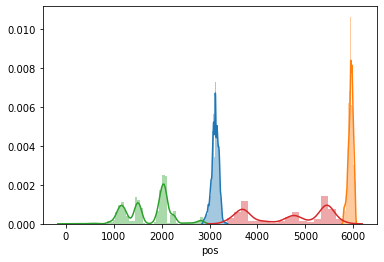

In [181]:
sns.distplot(test_0['pos'])
sns.distplot(test_1['pos'])
sns.distplot(test_2['pos'])
sns.distplot(test_3['pos'])

In [100]:
#fast!
for_bgm = [x for y in [[i]*n for i, n in read_stops_introns.items()] for x in y]

In [101]:
for_bgm = np.array(for_bgm).reshape([-1,1])

In [102]:
for_bgm.shape

(0, 1)

In [98]:
result = BayesianGaussianMixture(4,max_iter=300).fit(for_bgm).predict(for_bgm)

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 2 is required.

In [79]:
for_bgm.flatten().shape

(3107752,)

In [84]:
test = pd.DataFrame({'result':result,'pos':for_bgm.flatten(),'barcode':barcodes_test})

In [85]:
min = test[test['result']==0]['pos'].min()

In [86]:
max = test[test['result']==0]['pos'].max()

In [87]:
pd.Series(result).value_counts()

0    2166283
1     727600
3     110472
2     103397
dtype: int64

In [81]:
barcodes_test = [np.array(i).flatten() for i in barcodes_exons.values()]

In [82]:
barcodes_test = np.concatenate(barcodes_test)

In [83]:
barcodes_test.shape

(3107752,)

In [ ]:
temp = temp.groupby(['barcode','call']).count().reset_index()

In [187]:
test_2 = test2[test2['result'] == 2]

In [188]:
test_1 = test2[test2['result'] == 1]

In [189]:
test_0 = test2[test2['result'] == 0]

In [190]:
test_3 = test2[test2['result'] == 3]

In [92]:
import matplotlib.pyplot as plt

In [93]:
import seaborn as sns

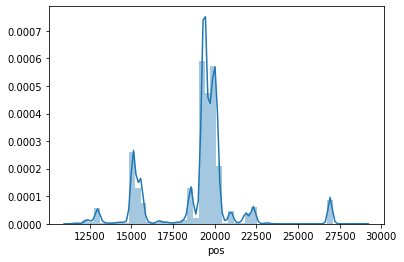

In [192]:
sns.distplot(test_0['pos'])


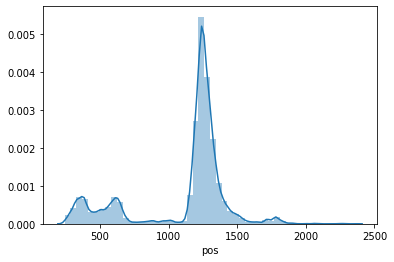

In [193]:
sns.distplot(test_1['pos'])

RuntimeError: Selected KDE bandwidth is 0. Cannot estiamte density.

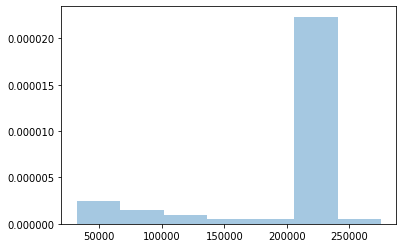

In [194]:
sns.distplot(test_2['pos'])

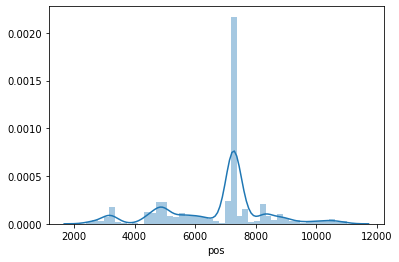

In [195]:
sns.distplot(test_3['pos'])